sources:

https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download

https://medium.com/@vineethrajesh2/loading-in-your-own-image-datasets-in-pytorch-9e4064171074

https://www.kaggle.com/code/agnesa/efficientnet-detect-ai-vs-human-generated-images

In [ ]:
#assorted
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns #literally only used for the lineplot? surely plt can do that too
from tqdm import tqdm
import random

#torch model
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F #difference between that and torch.relu or torch.nn.Module.maxpool2d etc?

#metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [2]:
#transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #mean and std for normalization
	transforms.RandomHorizontalFlip(), #randomly flip the image horizontally
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
#get num_workers, device, batch size
def count_workers() -> int: 
	try:
		vCPUs = os.cpu_count() 
		if vCPUs is None: 
			vCPUs = psutil.cpu_count(logical = False)
		return vCPUs
	except Exception as e:
		return 1
	

workers=count_workers()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 60
lr=0.001

print(f"cores: {workers}, device: {device}, batch_size: {batch_size}, epochs: {epochs}, learning rate: {lr}")

cores: 16, device: cuda, batch_size: 128, epochs: 60, learning rate: 0.001


In [4]:
#load actual data
train_data = ImageFolder("../data_test/train_subset", transform=train_transforms)
test_data = ImageFolder("../data_test/test_subset", transform=test_transforms)

#dataloaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate, #collate_fn is used to combine multiple samples into a batch
    num_workers=workers, #number of workers to LOAD data in parallel (not to crunch numbers. for some reason it's different)
    persistent_workers=True,
    pin_memory=True, #pin_memory is used to speed up data transfer to GPU
    pin_memory_device=str(device),
	)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    persistent_workers=True,
    pin_memory=True,
    pin_memory_device=str(device),
    )

In [5]:
#check how many images in the dataset
print(len(train_data)) #100k
print(len(test_data)) #20k

#check the classes
print(type(train_data)) #torchvision.datasets.folder.ImageFolder
# print(train_data.classes) #0 is fake and 1 is real
# print(test_data.classes)

#check the shape of the images
print(train_data[0][0].shape) #3 channels, 32 x 32 px
print(train_data[0]) #0 or 1, fake or real

4000
800
<class 'torchvision.datasets.folder.ImageFolder'>
torch.Size([3, 32, 32])
(tensor([[[0.3373, 0.3216, 0.3294,  ..., 0.3922, 0.3804, 0.3608],
         [0.3333, 0.3333, 0.3529,  ..., 0.4078, 0.3765, 0.3529],
         [0.3490, 0.3608, 0.3922,  ..., 0.4078, 0.3843, 0.3647],
         ...,
         [0.2667, 0.2549, 0.2549,  ..., 0.2941, 0.2902, 0.2863],
         [0.2824, 0.2667, 0.2549,  ..., 0.2824, 0.2667, 0.2549],
         [0.2784, 0.2588, 0.2431,  ..., 0.2196, 0.2000, 0.1843]],

        [[0.2588, 0.2431, 0.2431,  ..., 0.3529, 0.3216, 0.2941],
         [0.2549, 0.2549, 0.2667,  ..., 0.3686, 0.3176, 0.2941],
         [0.2627, 0.2745, 0.3020,  ..., 0.3765, 0.3333, 0.3137],
         ...,
         [0.1882, 0.1804, 0.1686,  ..., 0.1961, 0.1922, 0.1843],
         [0.2157, 0.2000, 0.1804,  ..., 0.1922, 0.1765, 0.1647],
         [0.2157, 0.1961, 0.1725,  ..., 0.1294, 0.1098, 0.0941]],

        [[0.2235, 0.2000, 0.2000,  ..., 0.2157, 0.2000, 0.1765],
         [0.2118, 0.2118, 0.2157,  ...,

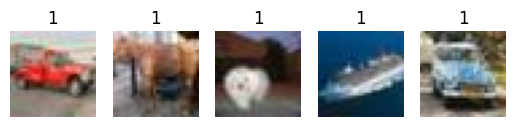

In [147]:
#print n images in train_data starting from starting_index
n_images = 5
starting_index=3908
for i in range(n_images):
	plt.subplot(1, 5, i + 1) #subplot with 1 row and 5 columns
	plt.imshow(train_data[starting_index + i][0].permute(1, 2, 0)) #permute to get channels last
	plt.title(train_data[starting_index + i][1]) #show the label of the image, 0 is the index of the image
	plt.axis('off') #remove axis
plt.show()

In [148]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [149]:
#initialize model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [150]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [151]:
#training loop
def train_cnn(model: nn.Module, train_loader, test_loader, epochs: int = 1000):
	print(f"Training on {device}")
	# Convert everything to tensors first
	loss_ls = []
	f1_ls = []
	model = model.to(device)

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_loader:
			features, target = features.to(device), target.to(device)	
			optimizer.zero_grad()
			outputs = model(features)
			loss = criterion(outputs, target)
			loss.backward()
			optimizer.step()

		model.eval()
		#with torch.no_grad():
		total_loss = 0
		combined = []
		for features, target in test_loader:
			features, target = features.to(device), target.to(device)
			output = model(features)
			loss = criterion(output, target)
			total_loss += loss.item()
			label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
			combined.append((label_out, target))
			
		f1 = [f1_score(c[0].cpu().numpy(), c[1].cpu().numpy()) for c in combined]
		loss_ls.append(total_loss / len(test_loader))
		f1_ls.append(np.mean(f1))
		print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_loader)} - F1 Score: {np.mean(f1)}")
	return loss_ls, f1_ls

In [152]:
loss_ls, f1_ls = train_cnn(model, train_loader, test_loader, epochs)

Training on cuda


  2%|▏         | 1/60 [01:07<1:06:14, 67.37s/it]

Epoch 1 - Loss: 0.685910484620503 - F1 Score: 0.5619047619047619


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  3%|▎         |

Epoch 2 - Loss: 0.7368269222123283 - F1 Score: 0.0


  5%|▌         | 3/60 [01:08<14:39, 15.44s/it]

Epoch 3 - Loss: 0.6957409467015948 - F1 Score: 0.12463013551877444


  7%|▋         | 4/60 [01:08<08:51,  9.49s/it]

Epoch 4 - Loss: 0.6803470083645412 - F1 Score: 0.2518044197768803


  8%|▊         | 5/60 [01:09<05:43,  6.24s/it]

Epoch 5 - Loss: 0.6426227603639875 - F1 Score: 0.4010724170140191


 10%|█         | 6/60 [01:09<03:48,  4.24s/it]

Epoch 6 - Loss: 0.679428539105824 - F1 Score: 0.27756962451978134


 12%|█▏        | 7/60 [01:09<02:37,  2.97s/it]

Epoch 7 - Loss: 0.6643644656453814 - F1 Score: 0.3187010759669023


 13%|█▎        | 8/60 [01:10<01:51,  2.14s/it]

Epoch 8 - Loss: 0.5668493594442096 - F1 Score: 0.5107156114893059


 15%|█▌        | 9/60 [01:10<01:21,  1.59s/it]

Epoch 9 - Loss: 0.5732428729534149 - F1 Score: 0.4656611206268741


 17%|█▋        | 10/60 [01:11<01:00,  1.21s/it]

Epoch 10 - Loss: 0.5500435616288867 - F1 Score: 0.5090613412307271


 18%|█▊        | 11/60 [01:11<00:46,  1.05it/s]

Epoch 11 - Loss: 0.6094673361097064 - F1 Score: 0.40293605862314047


 20%|██        | 12/60 [01:11<00:37,  1.29it/s]

Epoch 12 - Loss: 0.535073093005589 - F1 Score: 0.5095689831734913


 22%|██▏       | 13/60 [01:12<00:31,  1.51it/s]

Epoch 13 - Loss: 0.5333851831299918 - F1 Score: 0.49744144625275494


 23%|██▎       | 14/60 [01:12<00:25,  1.79it/s]

Epoch 14 - Loss: 0.5254009621483939 - F1 Score: 0.4982362989429735


 25%|██▌       | 15/60 [01:12<00:22,  2.04it/s]

Epoch 15 - Loss: 0.5191405117511749 - F1 Score: 0.5243468737185586


 27%|██▋       | 16/60 [01:13<00:19,  2.28it/s]

Epoch 16 - Loss: 0.5244442777974265 - F1 Score: 0.5335982804798522


 28%|██▊       | 17/60 [01:13<00:17,  2.45it/s]

Epoch 17 - Loss: 0.5166325782026563 - F1 Score: 0.49590499955440687


 30%|███       | 18/60 [01:13<00:16,  2.58it/s]

Epoch 18 - Loss: 0.5275563555104392 - F1 Score: 0.5387759352745238


 32%|███▏      | 19/60 [01:14<00:15,  2.69it/s]

Epoch 19 - Loss: 0.491528651544026 - F1 Score: 0.5223525521802225


 33%|███▎      | 20/60 [01:14<00:14,  2.75it/s]

Epoch 20 - Loss: 0.49719655939510893 - F1 Score: 0.5237779562411625


 35%|███▌      | 21/60 [01:14<00:14,  2.72it/s]

Epoch 21 - Loss: 0.503479506288256 - F1 Score: 0.47468108086664784


 37%|███▋      | 22/60 [01:15<00:13,  2.75it/s]

Epoch 22 - Loss: 0.5115986466407776 - F1 Score: 0.5381789092106047


 38%|███▊      | 23/60 [01:15<00:13,  2.77it/s]

Epoch 23 - Loss: 0.5004957914352417 - F1 Score: 0.4776417560324906


 40%|████      | 24/60 [01:15<00:13,  2.67it/s]

Epoch 24 - Loss: 0.4716325104236603 - F1 Score: 0.5068822673870029


 42%|████▏     | 25/60 [01:16<00:13,  2.63it/s]

Epoch 25 - Loss: 0.49781381658145357 - F1 Score: 0.4783604256587232


 43%|████▎     | 26/60 [01:16<00:12,  2.71it/s]

Epoch 26 - Loss: 0.48422385113579886 - F1 Score: 0.5381610769699511


 45%|████▌     | 27/60 [01:17<00:12,  2.73it/s]

Epoch 27 - Loss: 0.4895331178392683 - F1 Score: 0.475738086628139


 47%|████▋     | 28/60 [01:17<00:11,  2.75it/s]

Epoch 28 - Loss: 0.4599701889923641 - F1 Score: 0.5149464701633791


 48%|████▊     | 29/60 [01:17<00:11,  2.73it/s]

Epoch 29 - Loss: 0.4801862048251288 - F1 Score: 0.5420894597830559


 50%|█████     | 30/60 [01:18<00:11,  2.73it/s]

Epoch 30 - Loss: 0.4789197998387473 - F1 Score: 0.5420910066990505


 52%|█████▏    | 31/60 [01:18<00:10,  2.73it/s]

Epoch 31 - Loss: 0.451167847429003 - F1 Score: 0.5264162176609131


 53%|█████▎    | 32/60 [01:18<00:10,  2.77it/s]

Epoch 32 - Loss: 0.4523159989288875 - F1 Score: 0.4974295006088841


 55%|█████▌    | 33/60 [01:19<00:09,  2.83it/s]

Epoch 33 - Loss: 0.4491854693208422 - F1 Score: 0.4978873095133896


 57%|█████▋    | 34/60 [01:19<00:09,  2.85it/s]

Epoch 34 - Loss: 0.4393163323402405 - F1 Score: 0.5349246449893229


 58%|█████▊    | 35/60 [01:19<00:08,  2.89it/s]

Epoch 35 - Loss: 0.43629914096423555 - F1 Score: 0.5297767216315158


 60%|██████    | 36/60 [01:20<00:08,  2.89it/s]

Epoch 36 - Loss: 0.4311759386743818 - F1 Score: 0.5160495638466266


 62%|██████▏   | 37/60 [01:20<00:08,  2.84it/s]

Epoch 37 - Loss: 0.4417902571814401 - F1 Score: 0.5414038164873587


 63%|██████▎   | 38/60 [01:20<00:07,  2.91it/s]

Epoch 38 - Loss: 0.42822298407554626 - F1 Score: 0.5084999402166047


 65%|██████▌   | 39/60 [01:21<00:07,  2.95it/s]

Epoch 39 - Loss: 0.45166149735450745 - F1 Score: 0.4832319291148634


 67%|██████▋   | 40/60 [01:21<00:06,  2.95it/s]

Epoch 40 - Loss: 0.4293985962867737 - F1 Score: 0.5118323191345504


 68%|██████▊   | 41/60 [01:21<00:06,  2.90it/s]

Epoch 41 - Loss: 0.4543029878820692 - F1 Score: 0.46949134267508275


 70%|███████   | 42/60 [01:22<00:06,  2.85it/s]

Epoch 42 - Loss: 0.43089654190199717 - F1 Score: 0.4948813204044096


 72%|███████▏  | 43/60 [01:22<00:05,  2.91it/s]

Epoch 43 - Loss: 0.40551136221204487 - F1 Score: 0.5278167691352101


 73%|███████▎  | 44/60 [01:23<00:05,  2.95it/s]

Epoch 44 - Loss: 0.4235095850058964 - F1 Score: 0.5426091388433724


 75%|███████▌  | 45/60 [01:23<00:05,  2.87it/s]

Epoch 45 - Loss: 0.44557152475629536 - F1 Score: 0.5445711274650124


 77%|███████▋  | 46/60 [01:23<00:05,  2.78it/s]

Epoch 46 - Loss: 0.431942594902856 - F1 Score: 0.49070475681732834


 78%|███████▊  | 47/60 [01:24<00:05,  2.49it/s]

Epoch 47 - Loss: 0.41179889866283964 - F1 Score: 0.5330647520854678


 80%|████████  | 48/60 [01:24<00:05,  2.40it/s]

Epoch 48 - Loss: 0.41305577754974365 - F1 Score: 0.5238283258477879


 82%|████████▏ | 49/60 [01:25<00:04,  2.51it/s]

Epoch 49 - Loss: 0.4366466062409537 - F1 Score: 0.4797798177402011


 83%|████████▎ | 50/60 [01:25<00:03,  2.63it/s]

Epoch 50 - Loss: 0.3978119705404554 - F1 Score: 0.5159577093436843


 85%|████████▌ | 51/60 [01:25<00:03,  2.70it/s]

Epoch 51 - Loss: 0.4272357225418091 - F1 Score: 0.4887784394739669


 87%|████████▋ | 52/60 [01:26<00:02,  2.76it/s]

Epoch 52 - Loss: 0.40907215646335054 - F1 Score: 0.5016298307233422


 88%|████████▊ | 53/60 [01:26<00:02,  2.82it/s]

Epoch 53 - Loss: 0.4026218035391399 - F1 Score: 0.5450971524582294


 90%|█████████ | 54/60 [01:26<00:02,  2.86it/s]

Epoch 54 - Loss: 0.409173595053809 - F1 Score: 0.5259289901604337


 92%|█████████▏| 55/60 [01:27<00:01,  2.88it/s]

Epoch 55 - Loss: 0.39161682554653715 - F1 Score: 0.5188066492526603


 93%|█████████▎| 56/60 [01:27<00:01,  2.90it/s]

Epoch 56 - Loss: 0.3983626535960606 - F1 Score: 0.5211565382549016


 95%|█████████▌| 57/60 [01:27<00:01,  2.90it/s]

Epoch 57 - Loss: 0.3947032115289143 - F1 Score: 0.5362161804801564


 97%|█████████▋| 58/60 [01:28<00:00,  2.92it/s]

Epoch 58 - Loss: 0.3971274026802608 - F1 Score: 0.5162225989446707


 98%|█████████▊| 59/60 [01:28<00:00,  2.73it/s]

Epoch 59 - Loss: 0.39840985408851076 - F1 Score: 0.5431828512108774


100%|██████████| 60/60 [01:28<00:00,  1.48s/it]

Epoch 60 - Loss: 0.4021012080567224 - F1 Score: 0.5341260718004519


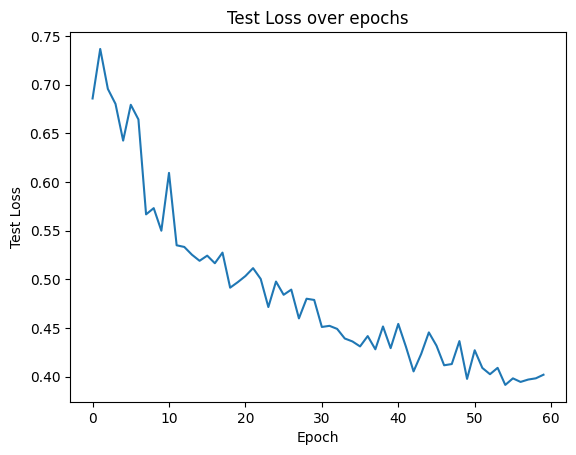

In [153]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

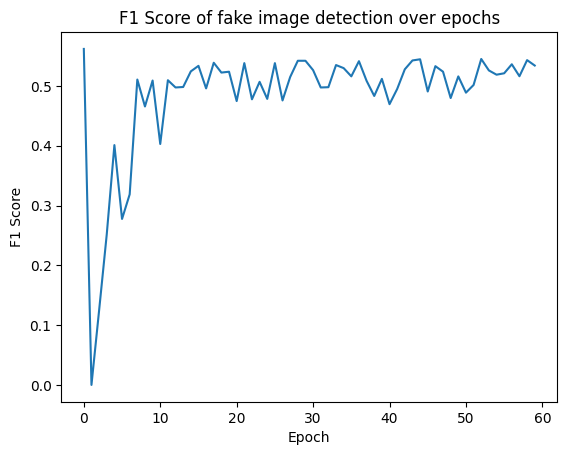

In [154]:
#test accuracy
sns.lineplot(f1_ls)
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score of fake image detection over epochs")
plt.show();

In [155]:
# #save the model
# torch.save(model.state_dict(), "model.pth")

In [159]:
def display_cam(index, target_layer):
	image_tensor = test_data[index]
	real_class=image_tensor[1]
	image=image_tensor[0].permute(1, 2, 0)
	image_tensor = image_tensor[0].unsqueeze(0)

	#load the model
	model = CNN()
	model.load_state_dict(torch.load("model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	#get the cam extractor
	cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

	#load the model
	model = CNN()
	model.load_state_dict(torch.load("model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	output = model(image_tensor.to(device))

	with SmoothGradCAMpp(model, target_layer=target_layer) as cam_extractor:
		output = model(image_tensor.to(device)) #move the image tensor to the same device as the model
		activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)


	#print actual vs prediction
	predicted_class = output.argmax(dim=1).item()# # Set your CAM extractor
	print(f"Index: {index}\nActual class: {"Fake (0)" if real_class==0 else "Real (1)"}, Predicted class: {"Fake (0)" if predicted_class==0 else "Real (1)"}")

	#overlay the CAM on the image
	result = overlay_mask(to_pil_image(image_tensor[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

	#plot
	#print n images in train_data starting from starting_index
	plt.subplot(1, 2, 1) #subplot with 1 row and 5 columns
	plt.title("Original Image")
	plt.imshow(image)
	plt.axis('off')
	plt.subplot(1, 2, 2)
	plt.title("CAM Overlay")
	plt.imshow(result)
	plt.axis('off')


In [ ]:
# Get a random image by index, as an image tensor
index=random.randint(0, 500) #randomly select an index from the test data
# ls=[400, 422, 437, 461, 464, 541, 542, 543, 550, 555, 569, 580, 597, 616, 646, 667, 714, 723, 758, 770, 790, 792, 799]
#real img pred fake

Index: 456
Actual class: Real (1), Predicted class: Real (1)


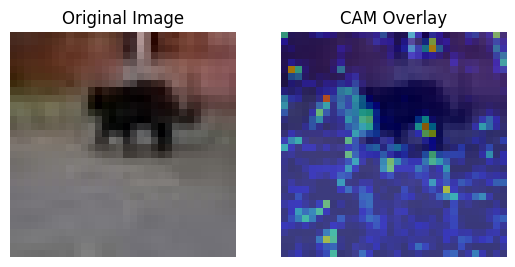

In [172]:
display_cam(index, target_layer="conv1")

Index: 456
Actual class: Real (1), Predicted class: Real (1)


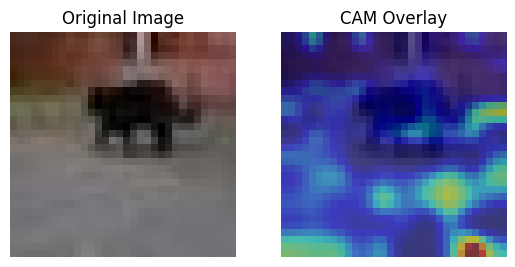

In [173]:
display_cam(index, target_layer="conv2")

[[294 106]
 [ 23 377]]


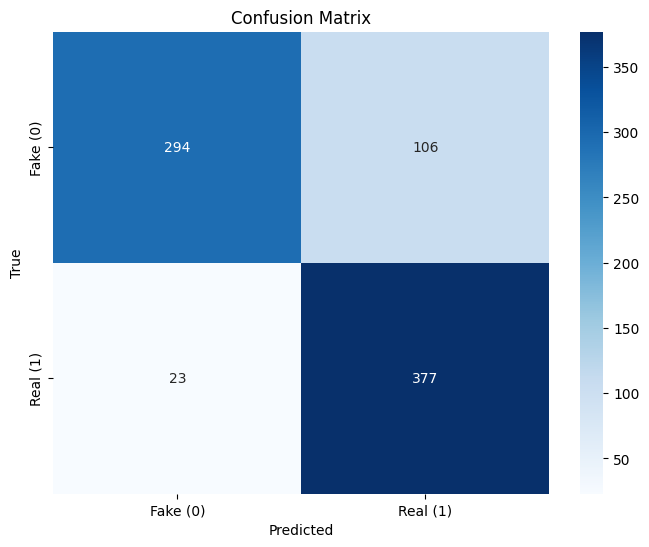

              precision    recall  f1-score   support

    Fake (0)       0.93      0.73      0.82       400
    Real (1)       0.78      0.94      0.85       400

    accuracy                           0.84       800
   macro avg       0.85      0.84      0.84       800
weighted avg       0.85      0.84      0.84       800



In [ ]:
model.eval()

# Get the predictions for the test set
y_true = []
y_pred = []
for features, target in test_loader:
	features, target = features.to(device), target.to(device)
	output = model(features)
	label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
	y_true.extend(target.cpu().numpy())
	y_pred.extend(label_out.cpu().numpy())


# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get the classification report
report = classification_report(y_true, y_pred, target_names=["Fake (0)", "Real (1)"])
print(report)

In [158]:
#get index of everything that's real but predicted fake

ls=[]

for i in range(len(y_pred)):
	if y_pred[i]==0 and y_true[i]==1:
		ls.append(i)

print(ls)

[400, 422, 437, 461, 464, 541, 542, 543, 550, 555, 569, 580, 597, 616, 646, 667, 714, 723, 758, 770, 790, 792, 799]


In [168]:
#save model
torch.save(model.state_dict(), "model_adamw.pth")